# **Kaggle: Car Price Prediction Challenge**

In this notebook, I'm going to train a model to predict the price of a car, using the [Car Price Prediction Challenge](https://www.kaggle.com/datasets/deepcontractor/car-price-prediction-challenge) from Kaggle dataset.

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.model_selection import train_test_split, RepeatedKFold, learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error,r2_score, mean_absolute_error

import warnings
warnings.simplefilter(action='ignore')

Before starting, let's read the dataset.

In [ ]:
df = pd.read_csv('data/car_price_prediction.csv')

df

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,45798355,8467,-,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.0,Manual,Rear,02-Mar,Left wheel,Silver,5
19233,45778856,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,04-May,Left wheel,Red,8
19234,45804997,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,116365 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
19235,45793526,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,51258 km,4.0,Automatic,Front,04-May,Left wheel,Black,4


## 1. Data analysis

In this section, the goal is treat the attributes of the dataset before train the model.

### 1.1 Attributes values correction

First of all let's see all the possible values that each attribute can take to see if there are any mistake due to the format of the dataset.


In [27]:
for column in df.columns:
    print(f"'{column}':")
    print(df[column].unique())
    print("\n")

'ID':
[45654403 44731507 45774419 ... 45804997 45793526 45813273]


'Price':
[13328 16621  8467 ... 56814 63886 22075]


'Levy':
['1399' '1018' '-' '862' '446' '891' '761' '751' '394' '1053' '1055'
 '1079' '810' '2386' '1850' '531' '586' '1249' '2455' '583' '1537' '1288'
 '915' '1750' '707' '1077' '1486' '1091' '650' '382' '1436' '1194' '503'
 '1017' '1104' '639' '629' '919' '781' '530' '640' '765' '777' '779' '934'
 '769' '645' '1185' '1324' '830' '1187' '1111' '760' '642' '1604' '1095'
 '966' '473' '1138' '1811' '988' '917' '1156' '687' '11714' '836' '1347'
 '2866' '1646' '259' '609' '697' '585' '475' '690' '308' '1823' '1361'
 '1273' '924' '584' '2078' '831' '1172' '893' '1872' '1885' '1266' '447'
 '2148' '1730' '730' '289' '502' '333' '1325' '247' '879' '1342' '1327'
 '1598' '1514' '1058' '738' '1935' '481' '1522' '1282' '456' '880' '900'
 '798' '1277' '442' '1051' '790' '1292' '1047' '528' '1211' '1493' '1793'
 '574' '930' '1998' '271' '706' '1481' '1677' '1661' '1286' '1408' '109

Looking at the values, there are several inconsistencies that need to be corrected.
 - ``Levy``: The column contains samples with a value of '-'. As this does not logically represent the absence of a levy, these values will be replaced with NaN to signify that the levy is unknown.

 - ``Doors``: Certain values, such as "04-May" and "02-Mar," appear due to a formatting issue in the CSV file. These will be corrected to represent 5 doors and 3 doors, respectively.

 - ``Mileage``: Some entries show '0 km', fact that doesn't make sense for older vehicles. These values will be replaced with NaN to indicate that the mileage is unknown.

 - ``Airbags``: Similar to "Mileage," entries with a value of 0 will be replaced with NaN to denote that the number of airbags is not provided.
 
 - ``ID``: This column is not useful for prediction and will be removed from the dataset.

In [28]:
df['Levy'] = df['Levy'].replace('-',np.nan)
df['Doors'] = df['Doors'].replace('04-May', 5)
df['Doors'] = df['Doors'].replace('02-Mar', 3)
df['Mileage'] = df['Mileage'].replace('0 km', np.nan)
df['Airbags'] = df['Airbags'].replace(0, np.nan)
df = df.drop('ID', axis=1)

df

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,5,Left wheel,Silver,12.0
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,5,Left wheel,Black,8.0
2,8467,NaN,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,5,Right-hand drive,Black,2.0
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,5,Left wheel,White,NaN
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,5,Left wheel,Silver,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,NaN,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.0,Manual,Rear,3,Left wheel,Silver,5.0
19233,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,5,Left wheel,Red,8.0
19234,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,116365 km,4.0,Automatic,Front,5,Left wheel,Grey,4.0
19235,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,51258 km,4.0,Automatic,Front,5,Left wheel,Black,4.0


To continue, let's see the types of each attribute of the dataset.

In [29]:
df.dtypes

Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags             float64
dtype: object

The ``Levy`` is currently of type object due to the presence of the '-' symbol. Similarly, the ``Mileage`` is also of type object because of the ' km' suffix in its values.

To revert this, let's convert these attributes to a numeric data type, ensuring they are appropriately formatted for analysis.

In [30]:
df['Levy'] = df['Levy'].astype('float64')
df['Mileage'] = df['Mileage'].str.replace(' km', '').astype('float64')

df.dtypes

Price                 int64
Levy                float64
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage             float64
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags             float64
dtype: object

This is the table with the attributes of the dataset after treatment:

| Variable            | Definition                                | Key                                                     | Type        |
|---------------------|-------------------------------------------|---------------------------------------------------------|-------------|
| ```Price```               | Price of the vehicle                      |                                                         | Numeric     |
| ```Levy```                | Tax/levy cost associated with the vehicle |                                                         | Numeric     |
| ```Manufacturer```        | Manufacturer of the vehicle               |                                                         | Categoric   |
| ```Model```               | Model of the vehicle                      |                                                         | Categoric   |
| ```Prod. year```          | Production year of the vehicle            |                                                         | Numeric     |
| ```Category```            | Category of the vehicle                   |                     | Categoric   |
| ```Leather interior```    | Presence of leather interior              | Yes, No                                                 | Binary      |
| ```Fuel type```        | Type of fuel used                         | Petrol, Diesel, Hybrid, CNG, LPG, Hydrogen, Plug-in Hybrid            | Categoric   |
| ```Engine volume```       | Engine capacity in liters                 |                                                         | Categoric     |
| ```Mileage```       | Total mileage of the vehicle              |                                   | Numeric     |
| ```Cylinders```           | Number of cylinders in the engine         |                                                         | Numeric     |
| ```Gear box type```      | Type of gearbox                           | Automatic, Manual, Tiptronic, Variator                              | Categoric   |
| ```Drive wheels```        | Type of drive wheels                      | Front, Rear, 4W4                             | Categoric   |
|```Doors```           | Number of doors                           | 3, 5, >5                                           | Categoric     |
|```Wheel```              | Steering wheel side                       | Left, Right                                    | Categoric   |
|```Color```             | Color of the vehicle                      |                                                         | Categoric   |
| ```Airbags```           | Number of airbags                         |                                                         | Numeric     |

## 2. Preprocessing

In this chapter, the objective is to prepare the dataset before training the model to achieve the best results. The first step will be to split the dataset into training and testing sets, allowing us to work on them separately and prevent data leakage.

In [31]:
y=df['Price']
X=df.drop('Price',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

Let's examine the percentage of NaN values in the training dataset.

In [32]:
percent_nan_col = train.isna().mean(axis=0)
percent_nan_col

Levy                0.300994
Manufacturer        0.000000
Model               0.000000
Prod. year          0.000000
Category            0.000000
Leather interior    0.000000
Fuel type           0.000000
Engine volume       0.000000
Mileage             0.037754
Cylinders           0.000000
Gear box type       0.000000
Drive wheels        0.000000
Doors               0.000000
Wheel               0.000000
Color               0.000000
Airbags             0.126714
Price               0.000000
dtype: float64

### 2.1 Outlier removals

Now, let's check if there is any correlation between the attributes of the training set and the target variable, ``Price``. By doing this, the data leakage will be avoided. Firstly, the correlations will be calculated for the numeric attributes, excluding the NaN values.

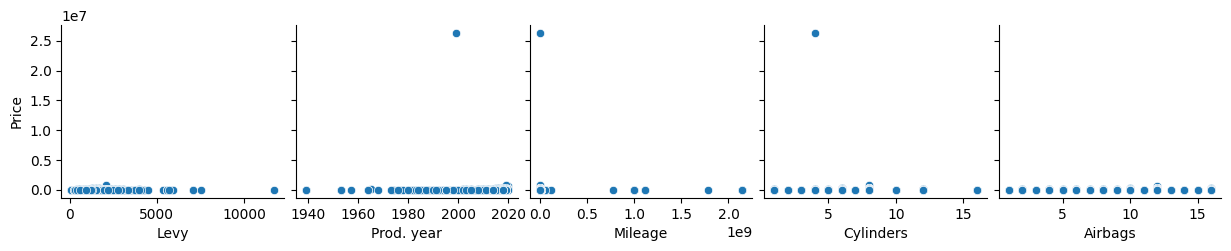

In [33]:
g= sns.pairplot(train,y_vars=['Price'], x_vars=df.select_dtypes(include='number').columns.drop('Price'), dropna=True)

This pairplot shows that there is at least one sample that is an outlier. Let's examine the distribution of the dataset before addressing this issue.

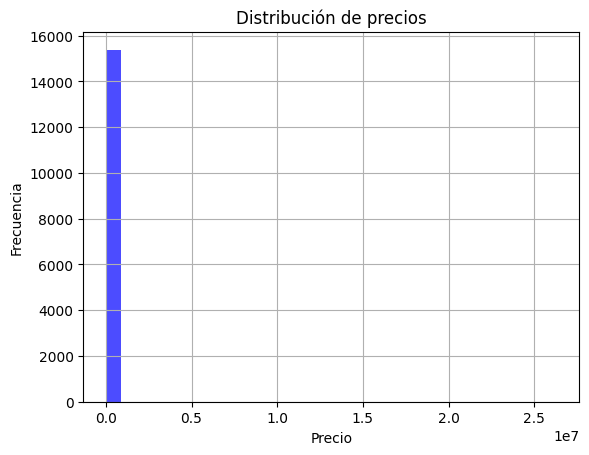

In [34]:
train['Price'].hist(bins=30, color='blue', alpha=0.7)
plt.title('Distribución de precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()


This histogram shows that there is one sample with an irrelevant. It's price exceeds 26 million, while the next highest price is below 1 million. Let's remove it before examining the distribution

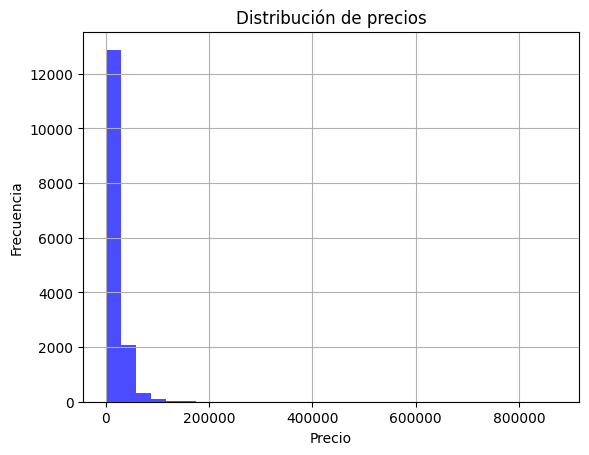

In [35]:
train = train.drop(index=train['Price'].idxmax())

train['Price'].hist(bins=30, color='blue', alpha=0.7)
plt.title('Distribución de precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

The distribution of the training set is asymmetric to the left, so let's combine the percentile and quantile methods to address this issue.

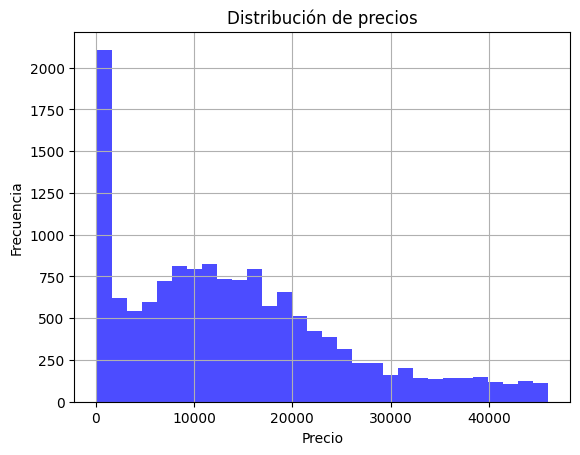

In [36]:
lower_percentile = train['Price'].quantile(0.02)
upper_percentile = train['Price'].quantile(0.98)

train = train[(train['Price'] >= lower_percentile) & (train['Price'] <= upper_percentile)]

Q1=train['Price'].quantile(0.25)
Q3=train['Price'].quantile(0.75)
IQR=Q3-Q1
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR

train = train[(train['Price'] >= lower_bound) & (train['Price'] <= upper_bound)]

train['Price'].hist(bins=30, color='blue', alpha=0.7)
plt.title('Distribución de precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

Before proceeding, the test dataset must experience the same outlier processing as the training dataset.

In [37]:
test = test[(test['Price'] >= lower_percentile) & (test['Price'] <= upper_percentile)]
test = test[(test['Price'] >= lower_bound) & (test['Price'] <= upper_bound)]

### 2.2 Correlations and feature selection

Now, finally, let's examine the correlations between the attributes and the target.

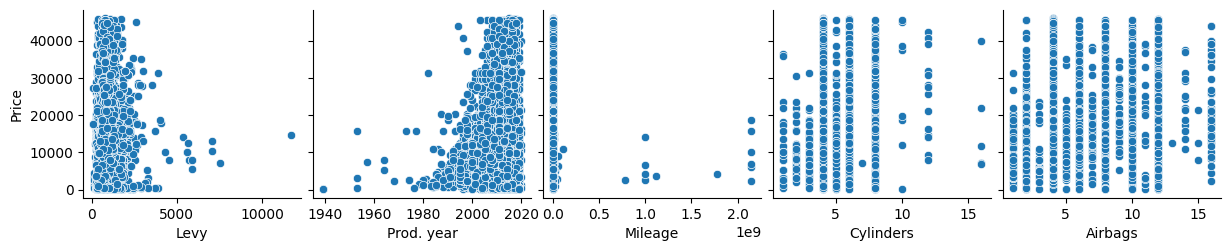

In [38]:
sns.pairplot(train,y_vars=['Price'], x_vars=df.select_dtypes(include='number').columns.drop('Price'), dropna=True)

<Axes: >

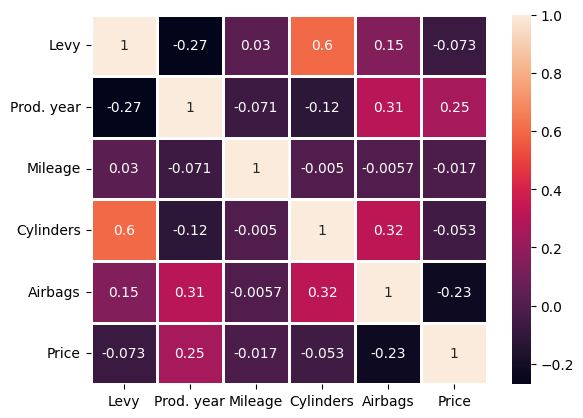

In [39]:
sns.heatmap(train.corr(numeric_only=True),annot=True,linewidths=2)

The analysis shows that the numeric attributes most strongly correlated with the target variable are ```Prod. year``` and ```Airbags```, while others have correlations below 0.1

#### 2.2.1 Encoding and normalization

Before encoding, it may be useful to combine the Manufacturer and Model columns into a single feature, as vehicles from the same brand can have different price ranges.

The best encoding method is ``TargetEncoder``, as it considers the relationship between categories and the target value. To ensure consistency, the train and test sets should be combined before applying the encoding.

In [40]:
n_train = train.shape[0]
df = pd.concat([train, test], axis=0)
df['Car'] = df['Manufacturer'] + ' ' + df['Model']
df['Doors'] = df['Doors'].astype(str)

X=df.drop(columns=['Price'])
y=df['Price']

te= TargetEncoder()
df_aux = te.fit_transform(X,y)
df_aux=pd.concat([df_aux, y], axis=1)
df = pd.DataFrame(df_aux, columns=df.columns)

df

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Price,Car
7808,779.0,12942.679614,11241.300221,2013,12514.447927,14461.502912,10354.711904,15369.958449,225510.0,4.0,13431.778072,14678.252625,14149.241993,14473.649159,14875.478017,12.0,314,11241.300221
16766,1282.0,13750.821773,17033.618040,2007,17000.725515,14461.502912,19774.942005,15636.349721,76198.0,4.0,13431.778072,14678.252625,14149.241993,14473.649159,14012.753889,4.0,6429,17033.618040
7285,1399.0,12744.884306,9275.330813,2010,12514.447927,14461.502912,19774.942005,10592.546931,189530.0,6.0,13431.778072,12572.477457,14149.241993,14473.649159,13914.100842,12.0,12388,9275.330813
15712,642.0,13750.821773,20775.532040,2012,17000.725515,14461.502912,19774.942005,15636.349721,218525.0,4.0,13431.778072,14678.252625,14149.241993,14473.649159,15429.601869,4.0,14834,20775.532040
16562,NaN,15529.801697,12631.838006,2000,17000.725515,14461.502912,13110.195627,11526.563843,25000.0,6.0,19390.543873,12572.477457,14149.241993,14473.649159,14012.753889,6.0,10036,12631.838006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12026,650.0,13750.821773,14218.581894,2016,12514.447927,13195.187863,13578.901671,17010.413062,9000.0,4.0,19390.543873,14678.252625,14149.241993,14473.649159,14790.121921,12.0,12231,14218.581894
17893,NaN,12281.363463,13743.376745,2003,16648.088435,13195.187863,19774.942005,18240.751793,250000.0,4.0,10652.336254,13436.841016,14149.241993,14473.649159,14875.478017,2.0,15681,13743.376745
5339,2410.0,12744.884306,9275.330813,2010,12514.447927,14461.502912,13578.901671,8695.266460,274771.0,8.0,13431.778072,13436.841016,14149.241993,14473.649159,14875.478017,12.0,314,9275.330813
11859,687.0,19124.767292,16221.699557,2010,12514.447927,14461.502912,13578.901671,15930.648290,100403.0,4.0,13431.778072,14678.252625,14149.241993,14473.649159,14875.478017,4.0,14069,16221.699557


Now that the dataset is encoded, the next step is to normalize it using MinMaxScaler, as the dataset no longer contains any atypical values due to the outlier processing applied earlier.

In [41]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)

df

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Price,Car
0,0.059517,0.320252,0.223504,0.913580,0.264004,1.0,0.128698,0.415484,0.000105,0.200000,0.318079,1.000000,0.360674,1.0,0.814729,0.733333,0.004660,0.223504
1,0.102778,0.353497,0.427897,0.839506,0.689492,1.0,0.804723,0.428152,0.000035,0.200000,0.318079,1.000000,0.360674,1.0,0.689638,0.200000,0.137821,0.427897
2,0.112841,0.312116,0.154131,0.876543,0.264004,1.0,0.804723,0.188307,0.000088,0.333333,0.318079,0.000000,0.360674,1.0,0.675333,0.733333,0.267584,0.154131
3,0.047734,0.353497,0.559937,0.901235,0.689492,1.0,0.804723,0.428152,0.000102,0.200000,0.318079,1.000000,0.360674,1.0,0.895075,0.200000,0.320848,0.559937
4,NaN,0.426679,0.272572,0.753086,0.689492,1.0,0.326440,0.232722,0.000012,0.333333,1.000000,0.000000,0.360674,1.0,0.689638,0.333333,0.216367,0.272572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17694,0.048422,0.353497,0.328563,0.950617,0.264004,0.0,0.360076,0.493492,0.000004,0.200000,1.000000,1.000000,0.360674,1.0,0.802353,0.733333,0.264165,0.328563
17695,NaN,0.293048,0.311795,0.790123,0.656047,0.0,0.804723,0.551997,0.000116,0.200000,0.000000,0.410473,0.360674,1.0,0.814729,0.066667,0.339293,0.311795
17696,0.199794,0.312116,0.154131,0.876543,0.264004,1.0,0.360076,0.098087,0.000128,0.466667,0.318079,0.410473,0.360674,1.0,0.814729,0.733333,0.004660,0.154131
17697,0.051604,0.574564,0.399247,0.876543,0.264004,1.0,0.360076,0.442146,0.000047,0.200000,0.318079,1.000000,0.360674,1.0,0.814729,0.200000,0.304190,0.399247


Now, let's split the dataset into training and testing sets again to proceed.

In [42]:
train = df[:n_train]
test = df[n_train:]

Now that all attributes are numeric, let's check if there is any correlation between the attributes and the target using all the attributes.

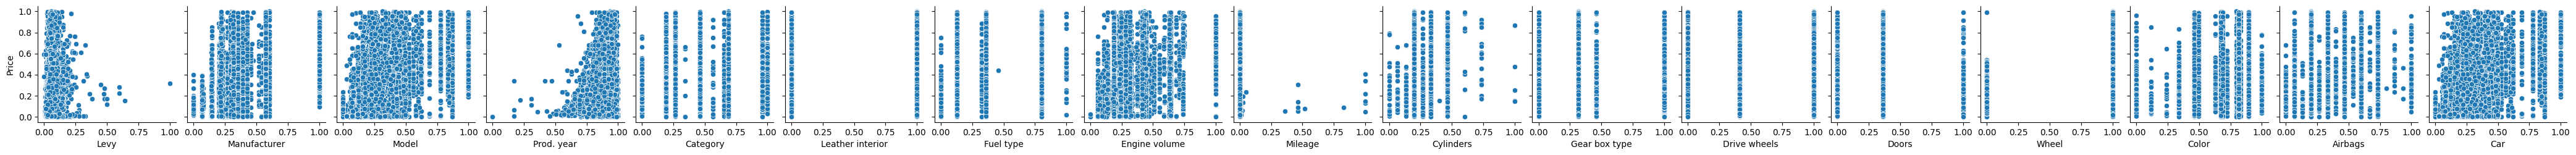

In [43]:
sns.pairplot(train,y_vars=['Price'], x_vars=df.select_dtypes(include='number').columns.drop('Price'), dropna=True)

<Axes: >

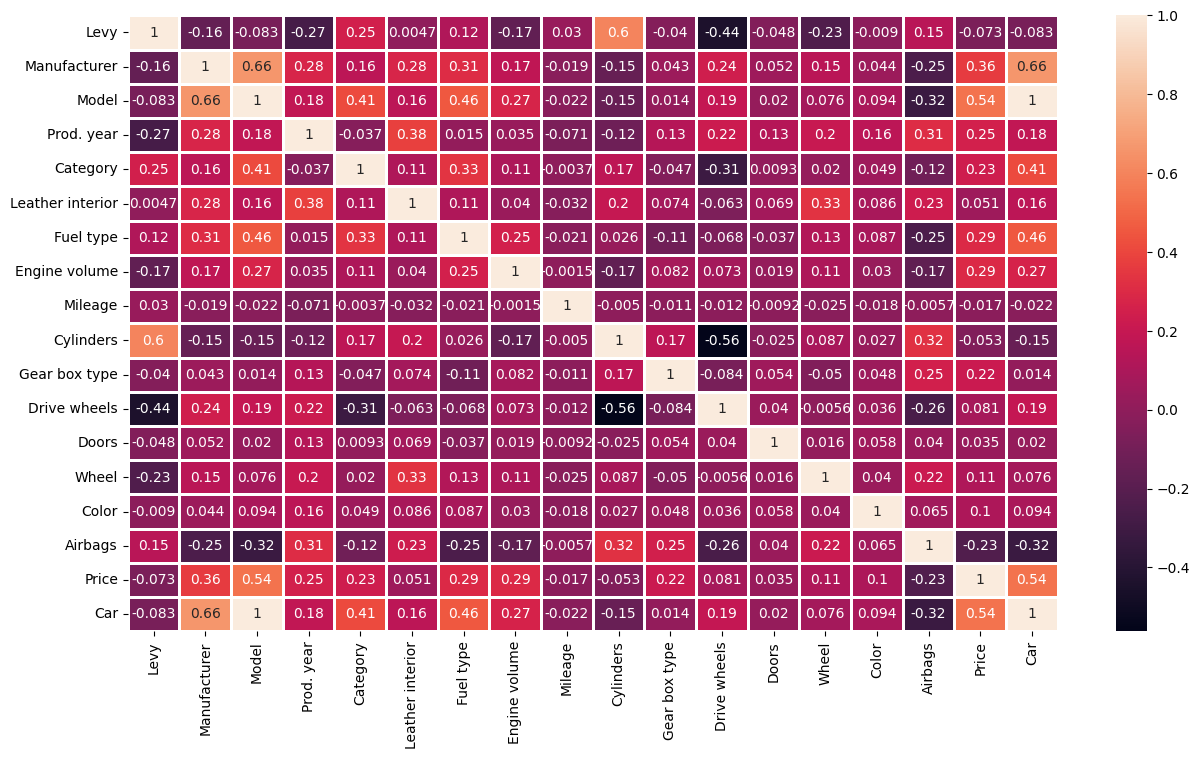

In [44]:
plt.figure(figsize=(15,8))

sns.heatmap(train.corr(numeric_only=True),annot=True,linewidths=2)

Based on this correlation information, let's select a threshold and remove all columns with a correlation of less than 0.1 with the target.

In [45]:
llindar = 0.2

correlations = train.corr()["Price"]
seleccionades = correlations[correlations.abs() > llindar].index
train = train[seleccionades]
test = test[seleccionades]

train

,Manufacturer,Model,Prod. year,Category,Fuel type,Engine volume,Gear box type,Airbags,Price,Car
0,0.320252,0.223504,0.913580,0.264004,0.128698,0.415484,0.318079,0.733333,0.004660,0.223504
1,0.353497,0.427897,0.839506,0.689492,0.804723,0.428152,0.318079,0.200000,0.137821,0.427897
2,0.312116,0.154131,0.876543,0.264004,0.804723,0.188307,0.318079,0.733333,0.267584,0.154131
3,0.353497,0.559937,0.901235,0.689492,0.804723,0.428152,0.318079,0.200000,0.320848,0.559937
4,0.426679,0.272572,0.753086,0.689492,0.326440,0.232722,1.000000,0.333333,0.216367,0.272572
...,...,...,...,...,...,...,...,...,...,...
14148,1.000000,1.000000,0.975309,0.689492,0.360076,0.442146,0.318079,0.200000,0.972344,1.000000
14149,0.320252,0.223504,0.975309,0.264004,0.128698,0.415484,0.318079,0.733333,0.407582,0.223504
14150,0.426679,0.272572,0.925926,0.689492,0.804723,0.232722,0.318079,NaN,0.359762,0.272572
14151,0.426679,0.226172,0.814815,0.264004,0.360076,0.415484,1.000000,0.733333,0.270981,0.226172


The next step will be to separate the attributes from the target.

In [46]:
y_train = train["Price"]
X_train = train.drop("Price", axis="columns")

y_test = test["Price"]
X_test = test.drop("Price", axis="columns")

The next step is to deal with the NaNs in the data set, first in the training set and then in the test set to avoid data leakage.

In [47]:
X_train=X_train.fillna(X_train.mean())
X_test=X_test.fillna(X_test.mean())

## 3. Model selection

The final step will be to train the model and predict the target.

For this dataset, the chosen metric will be R² because it shows the relationship between the attributes and the price. It tends to perform bad with irrelevant attributes and outliers, but these have been removed in the previous steps.

In [48]:
repeated_kfold = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

pipe = Pipeline([('estimator', 'passthrough')])

param_grid = [
    {'estimator': [LinearRegression(n_jobs=-1)]}, 
    {'estimator': [Lasso()],
     'estimator__alpha': Real(0.001, 10, prior='log-uniform')},
    {'estimator': [Ridge()],
     'estimator__alpha': Real(0.001, 10, prior='log-uniform')},
    {'estimator': [SVR()],
     'estimator__C': Real(0.01, 100, prior='log-uniform'),
     'estimator__kernel': Categorical(['linear', 'rbf'])},
    {'estimator': [RandomForestRegressor(n_jobs=-1)],
     'estimator__n_estimators': Integer(50, 300),
     'estimator__max_depth': Integer(5, 30)}
]

search = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_grid,
    cv=repeated_kfold,
    n_jobs=-1,
    scoring=make_scorer(r2_score),
    random_state=42
)

search.fit(X_train, y_train)

results = search.cv_results_
resultats = pd.DataFrame({
    'Model': [', '.join([f"{key.replace('estimator__', '')}: {value}" for key, value in params.items()]) for params in results['params']],
    'Score': results['mean_test_score'],
    'Temps': results['mean_fit_time'] 
})

pd.set_option('display.max_colwidth', None)
resultats = resultats.sort_values(by='Score', ascending=False).reset_index(drop=True)
resultats


,Model,Score,Temps
0,"estimator: RandomForestRegressor(n_jobs=-1), max_depth: 17, n_estimators: 267",0.697797,6.132711
1,"estimator: RandomForestRegressor(n_jobs=-1), max_depth: 17, n_estimators: 257",0.697738,6.235436
2,"estimator: RandomForestRegressor(n_jobs=-1), max_depth: 16, n_estimators: 299",0.697670,6.251018
3,"estimator: RandomForestRegressor(n_jobs=-1), max_depth: 18, n_estimators: 300",0.697664,6.911708
4,"estimator: RandomForestRegressor(n_jobs=-1), max_depth: 17, n_estimators: 262",0.697635,6.288177
...,...,...,...
245,"estimator: Lasso(), alpha: 0.17171984308672647",-0.000206,0.006645
246,"estimator: Lasso(), alpha: 0.026818805326217342",-0.000206,0.006449
247,"estimator: Lasso(), alpha: 4.577324248754909",-0.000206,0.005120
248,"estimator: Lasso(), alpha: 2.1425632591165393",-0.000206,0.005106


#### **Random Forest**

| Paràmetre      | Valor       |
|----------------|-------------|
| max_depth      | 17           |
| n_estimators   | 296          |
| $R^2$          | 0.70 |

## 4. Final analysis and model evaluation

In this chapter, the selected model will be analysed to determine its performance on the test set.

In [49]:
model = RandomForestRegressor(n_jobs=-1, max_depth=17, n_estimators=296, random_state=42)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)

r2_test = r2_score(y_test, predictions_test)
mae_test = mean_absolute_error(y_test, predictions_test)

r2_train = r2_score(y_train, predictions_train)
mae_train = mean_absolute_error(y_train, predictions_train)


results = pd.DataFrame({
    'Metric': ['MAE','R²'],
    'Train Set': [mae_train, r2_train],
    'Test Set': [mae_test, r2_test]
})

results

,Metric,Train Set,Test Set
0,MAE,0.057571,0.083994
1,R²,0.854309,0.711058


Looking at the results, the model performs well on the test set, with an R² of 0.71. However, the training set shows better performance on both metrics, which may indicate that the model is experiencing some overfitting.

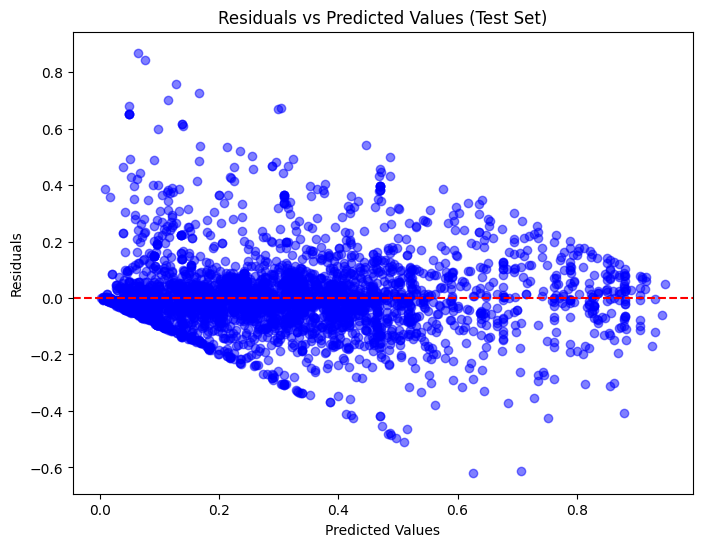

In [50]:
residuals_test = y_test - predictions_test
plt.figure(figsize=(8, 6))
plt.scatter(predictions_test, residuals_test, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values (Test Set)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


In this graphic, the residuals are centered around zero but follow a conical pattern, which indicates that the model is performing well, though with some overfitting.

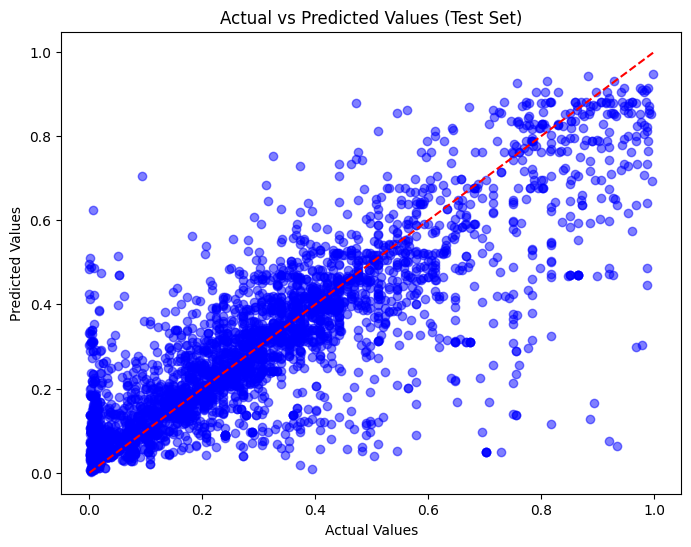

In [51]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions_test, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') 
plt.title('Actual vs Predicted Values (Test Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


In this graphic, the actual and predicted values are close to the diagonal line, which indicates that the model is performing well.

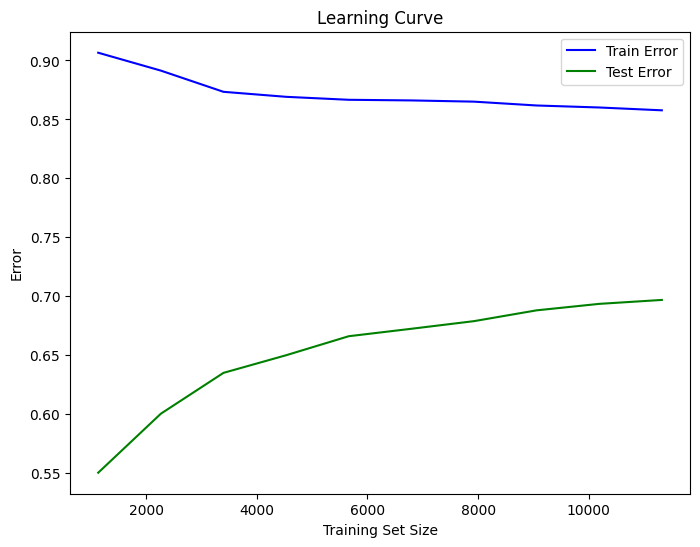

In [52]:
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Promediar los scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Train Error', color='blue')
plt.plot(train_sizes, test_mean, label='Test Error', color='green')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.legend()
plt.show()


This graphic also shows that the model is performing well on both training and test sets, but with some overfitting, which is visible in the learning curve.